In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1


In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
import numpy as np
import glob
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers,losses,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.optimizers import RMSprop
import warnings 
warnings.filterwarnings('ignore')



In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gzip
%matplotlib inline


In [4]:
import glob
data_dir="C:/Users/DELL/Downloads/DB1_B/"
list_dirs=list(glob.glob(data_dir+"*.tif"))
num_images=len(list_dirs)
print(num_images)

80


In [5]:
images = []
def read_images(data):
    for i in range(len(data)):
        img = cv2.imread(data[i])
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img=cv2.resize(img,(224,224))
        images.append(img)
    return images


In [6]:
images = read_images(list_dirs)

In [7]:
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')


In [8]:
images_arr.shape


(80, 224, 224)

In [9]:
# Shapes of training set
print("Dataset (images) shape: {shape}".format(shape=images_arr.shape))


Dataset (images) shape: (80, 224, 224)


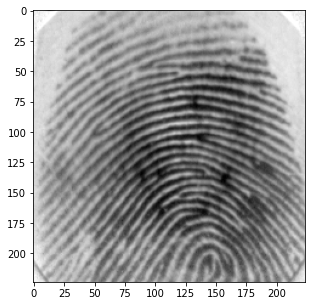

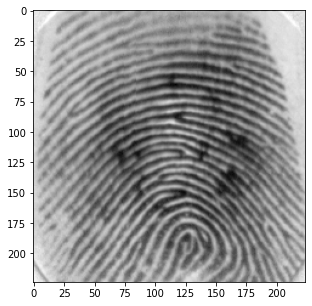

In [10]:
#plt.figure(figsize=[5,5])

# Display the first image in training data
for i in range(2):
    plt.figure(figsize=[5, 5])
    curr_img = np.reshape(images_arr[i], (224,224))
    plt.imshow(curr_img, cmap='gray')
    plt.show()


In [11]:
images_arr = images_arr.reshape(-1, 224,224, 1)


In [12]:
images_arr.shape


(80, 224, 224, 1)

In [13]:
images_arr.dtype


dtype('float32')

In [14]:
np.max(images_arr)


250.0

In [15]:
images_arr = images_arr / np.max(images_arr)


In [16]:
np.max(images_arr), np.min(images_arr)


(1.0, 0.268)

In [17]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr,
                                                             images_arr,
                                                             test_size=0.2,
                                                             random_state=13)


In [18]:
batch_size = 10
epochs = 5
inChannel = 1
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))


In [19]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(10, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(10, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(12, (3, 3), activation='relu', padding='same')(pool2) 

    #decoder
    conv4 = Conv2D(12, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(10, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded


In [20]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())


In [21]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 10)      100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 10)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 12)        1092  

In [22]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Epoch 1/5
7/7 [==============================] - 7s 726ms/step - loss: 0.0528 - val_loss: 0.0228
Epoch 2/5
7/7 [==============================] - 5s 680ms/step - loss: 0.0167 - val_loss: 0.0157
Epoch 3/5
7/7 [==============================] - 5s 689ms/step - loss: 0.0140 - val_loss: 0.0149
Epoch 4/5
7/7 [==============================] - 5s 664ms/step - loss: 0.0151 - val_loss: 0.0130
Epoch 5/5
7/7 [==============================] - 5s 681ms/step - loss: 0.0139 - val_loss: 0.0119


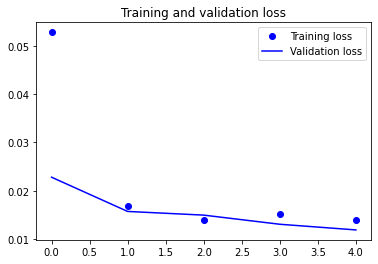

In [23]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(5)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
